<a href="https://colab.research.google.com/github/MihaiDogariu/CV3/blob/main/laborator/CV%203%20-%20Lab%20%235.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Image Retrieval
Acest proiect implementeaza o retea neuronala pentru clasificarea imaginilor reale si foloseste descriptorii extrasi cu ajutorul ei pentru a efectua image retrieval. Baza de date aleasa pentru demonstratie este CIFAR10.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm
import matplotlib.pyplot as plt


# Alegem configuratia sistemului (cpu/gpu)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Setam media si deviatia standard pentru normalizarea bazei de date - acestea sunt calculate la nivel de canal si doar pe baza de date de antrenare!
mean=[0.4914, 0.4822, 0.4465]
std=[0.2023, 0.1994, 0.2010]
normalize = transforms.Normalize(mean, std)

##1. Pre-procesarea datelor

In [ ]:
def get_train_valid_loader(data_dir,
                           batch_size,
                           augment,
                           random_seed,
                           normalize,
                           valid_size=0.1,
                           shuffle=True):

    # Definim setul de transformari necesare bazei de date
    valid_transform = transforms.Compose([
            transforms.Resize((227,227)), # baza de date CIFAR10 contine imagini de dimensiunea 32x32, iar AlexNet are intrari de dimensiune 227x227
            transforms.ToTensor(),        # transformarea intrarilor in tensori
            normalize,                    # aplicarea normalizarii
    ])
    if augment:
        train_transform = transforms.Compose([
            # transforms.RandomCrop(32, padding=4), # decuparea unor regiuni aleatoare de dimensiune 32x32 din imaginea originala la care s-a adaugat padding=4
            transforms.RandomHorizontalFlip(0.4), # oglindirea imaginilor cu probabilitate de 40%
            transforms.Resize((227,227)),         # redimensionarea imaginilor augmentate la dimensiunea de 227x227 pixeli
            transforms.ToTensor(),                # transformarea intrarilor in tensori
            normalize,                            # aplicarea normalizarii
        ])
    else:
        train_transform = valid_transform

    # Fiind o baza de date foarte populara, CIFAR10 poate fi descarcata cu ajutorul modulului torchvision       
    train_dataset = datasets.CIFAR10(root=data_dir,                
                                     train=True,
                                     download=True, 
                                     transform=train_transform,   
                                     )

    valid_dataset = datasets.CIFAR10(root=data_dir, 
                                     train=True,
                                     download=True, 
                                     transform=valid_transform,
                                     )

    # Alegem numarul de esantioane pentru train/val
    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    # Amestecam indecsii
    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    # Separam indecsii de train in train+val
    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # Cream dataloaders pentru train si val
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler)
 
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)


def get_test_loader(data_dir,
                    batch_size,
                    normalize,
                    shuffle=True):

    # Transformari asemanatoare cu cele pentru train/val. Normalizarea se face cu aceleasi valori ca in cazul train!
    transform = transforms.Compose([
        transforms.Resize((227,227)),
        transforms.ToTensor(),
        normalize,
    ])

    # Descarcarea bazei de test
    dataset = datasets.CIFAR10(
        root=data_dir, train=False,
        download=True, transform=transform,
    )

    # Crearea dataloader pentru test
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle
    )

    return data_loader


# Crearea efectiva a dataloaders
train_loader, valid_loader = get_train_valid_loader(
    data_dir = './data',     
    batch_size = 64,
    augment = True,                             		     
    random_seed = 1,
    normalize = normalize
)

test_loader = get_test_loader(
    data_dir = './data',
    batch_size = 64,
    normalize = normalize
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


Pentru a vizualiza corect imaginile care au fost deja normalizate, trebuie sa le "denormalizam". Clasa de mai jos implementeaza operatia inversa normalizarii. Apeland-o pentru o imagine normalizata, se va obtine imaginea originala, care poate fi afisata corect.

In [ ]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
        
unorm = UnNormalize(mean, std)

Exemplu de acces al unei imagini din baza de date folosind obiectul de tip DataLoader.

Feature batch shape: torch.Size([64, 3, 227, 227])
Labels batch shape: torch.Size([64])


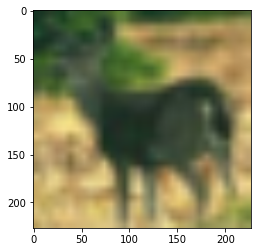

In [ ]:
train_features, train_labels = next(iter(train_loader)) # se extrage un batch de imagini si etichete din baza de date cu ajutorul unui dataloader
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()     # se extrage prima imagine din batch si sunt eliminate dimensiunile de valoare 1
img = unorm(img)                      # se "denormalizeaza" imaginea
npimg = img.numpy()                   # se transforma tensorul in nparray
img = np.transpose(npimg, (1, 2, 0))  # imaginile din CIFAR-10 au dimensiunea 3x32x32 (scalata la 3x227x227) - pentru a fi vizualizate corect, acestea trebuie transpuse in 227x227x3
label = train_labels[0]
plt.imshow(img)
plt.show()
print(f"Label: {label}")

##2. Definirea modelului

Puteti folosi si alt model de retea decat AlexNet. Modele mai putin adanci ar putea fi utilizate cu succes, data fiind dimensiunea redusa a imaginilor.

In [ ]:
# class AlexNet(nn.Module):
#     def __init__(self, num_classes=10):
#         super(AlexNet, self).__init__()
#         self.layer1 = nn.Sequential(
#             nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
#             nn.BatchNorm2d(96),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size = 3, stride = 2))
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size = 3, stride = 2))
#         self.layer3 = nn.Sequential(
#             nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(384),
#             nn.ReLU())
#         self.layer4 = nn.Sequential(
#             nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(384),
#             nn.ReLU())
#         self.layer5 = nn.Sequential(
#             nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size = 3, stride = 2))
#         self.fc = nn.Sequential(
#             nn.Dropout(0.5),
#             nn.Linear(9216, 4096),
#             nn.ReLU())
#         self.fc1 = nn.Sequential(
#             nn.Dropout(0.5),
#             nn.Linear(4096, 4096),
#             nn.ReLU())
#         self.fc2= nn.Sequential(
#             nn.Linear(4096, num_classes))
        
#     def forward(self, x):
#         out = self.layer1(x)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.layer4(out)
#         out = self.layer5(out)
#         out = out.reshape(out.size(0), -1)
#         out = self.fc(out)
#         out = self.fc1(out)
#         out = self.fc2(out)
#         return out

Label: 4


##3. Antrenarea retelei

In [ ]:
# Alegerea hiperparametrilor
num_classes = 10
num_epochs = 20
batch_size = 64
learning_rate = 0.005

# Trecerea modelului pe gpu
model = AlexNet(num_classes).to(device)

# Alegerea functiei de pierdere. Clasificare de imagini => cross-entropy
criterion = nn.CrossEntropyLoss()
# Alegerea optimizatorului
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

NameError: ignored

In [ ]:
# Antrenarea modelului
total_step = len(train_loader)

for epoch in tqdm(range(num_epochs)):
    for i, (images, labels) in enumerate(train_loader):  
        # Incarcam tensorii pe gpu/cpu
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward propagation
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backprop si rularea unui pas de optimizare a ponderilor
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
    # Rularea algoritmului pe baza de validare
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total)) 


##4. Testarea retelei

In [ ]:
# Rularea algoritmului pe baza de test
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))   

Fluxul de procesari pentru aceasta lucrare se compune din urmatorii pasi:
1. antrenarea unui model de clasificare a imaginilor pe baza de date CIFAR-10. Rularea pasilor:
  - antrenare pe `train`, testare pe `val`;
  - optimizare hiperparametri;
  - antrenare pe `train+val`, testare pe `test` - retinere metrici.
2. alegerea unei imagini aleatoare din baza de date (query image);
3. extragerea descriptorului de trasaturi al imaginii alese;
4. parcurgerea intregii baze de date (`train` + `val` + `test`) si extragerea descriptorului de trasaturi al fiecarei imagini, in parte;
5. compararea descriptorului query cu descriptorul fiecarei imagini si retinerea distantei dintre cei 2 descriptori (se poate folosi distanta euclidiana sau distanta cosinus);
6. ordonarea distantelor dintre query si imagini;
7. determinarea celei mai asemanatoare imagini pe baza distantei minime; 
8. alegerea top-k a rezultatelor;
9. calcularea metricilor `precision` si `recall`.

#\#TODO:
1. implementati fluxul descris mai sus;
2. incercati sa extrageti descriptorii de trasaturi din diferite straturi ale retelei neuronale;
3. rulati antrenarea modelului cu 1, 2, 5, 10, 20 epoci si urmariti cum anume se modifica metricile;
4. incercati concatenarea descriptorilor de pe diferite straturi si urmariti efectul asupra metricilor - teoretic, fiecare strat aduce o contributie in plus la reprezentarea finala si descrierea imaginii ar trebui sa fie mai completa.